# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (UTI), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [49]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

In [50]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [51]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [52]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [53]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [54]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [55]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [56]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [57]:
data.shape

(360000, 229)

In [58]:
data.deregistered_date.value_counts()

2020-02-01    29
2021-11-12    27
2020-08-29    27
2021-07-26    26
2020-06-21    26
              ..
2020-01-30     7
2019-02-14     6
2020-07-16     6
2019-04-14     5
2021-02-28     3
Name: deregistered_date, Length: 1135, dtype: int64

In [59]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,admitted_date,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,342000,36000,36000,36000,36000,36000,36000,0.0,180000,108000,...,360000.0,360000.0,360000.0,360000.0,360000.0,360000.0,360000.0,360000.0,360000.000000,360000
unique,38,38,38,13,13,1135,1135,NaN,890,1135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2019-03,2019-10,2020-10,2018-05,2018-03,2021-08-12,2019-03-17,NaN,2022-02-07,2019-02-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,9522,1055,1045,3151,3132,56,49,NaN,1585,129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,49967.134078,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,28876.556509,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24966.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49962.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74940.000000,NaN


In [60]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'deregistered_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_sinusitis_1', 'gp_cons_sinusitis_2', 'gp_cons_sinusitis_3', 'gp_cons_sinusitis_4', 'gp_cons_otmedia_1', 'gp_cons_otmedia_2', 'gp_cons_otmedia_3', 'gp_cons_otmedia_4', 'gp_cons_ot_externa_1', 'g

In [61]:
# define dictionaries
dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [62]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [63]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [64]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [65]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     47569
3.0     46205
4.0     42780
1.0     42745
0.0     33986
5.0     31514
6.0     28756
7.0     22423
8.0     17488
9.0     13722
10.0    10931
11.0     7607
12.0     5286
13.0     3511
14.0     2126
15.0     1327
16.0      904
17.0      476
18.0      301
19.0      165
20.0       84
21.0       57
22.0       26
24.0        7
23.0        3
25.0        1
Name: CCI, dtype: int64

In [66]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Underweight', 'Healthy weight', 
                                                                                    'Overweight', 'Obese'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

In [161]:
dict_BMI_cat= {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
                np.nan: 'Unknown'}
data = data.replace({"BMI_cat": dict_BMI_cat})

dict_gp_count_cat= {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
data = data.replace({"gp_count_cat": dict_gp_count_cat})

dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
                       np.nan: 'Unknown'}
data = data.replace({"smoking_status": dict_smoking_status})

## 2- Plots
### 2-1- Continuous factors

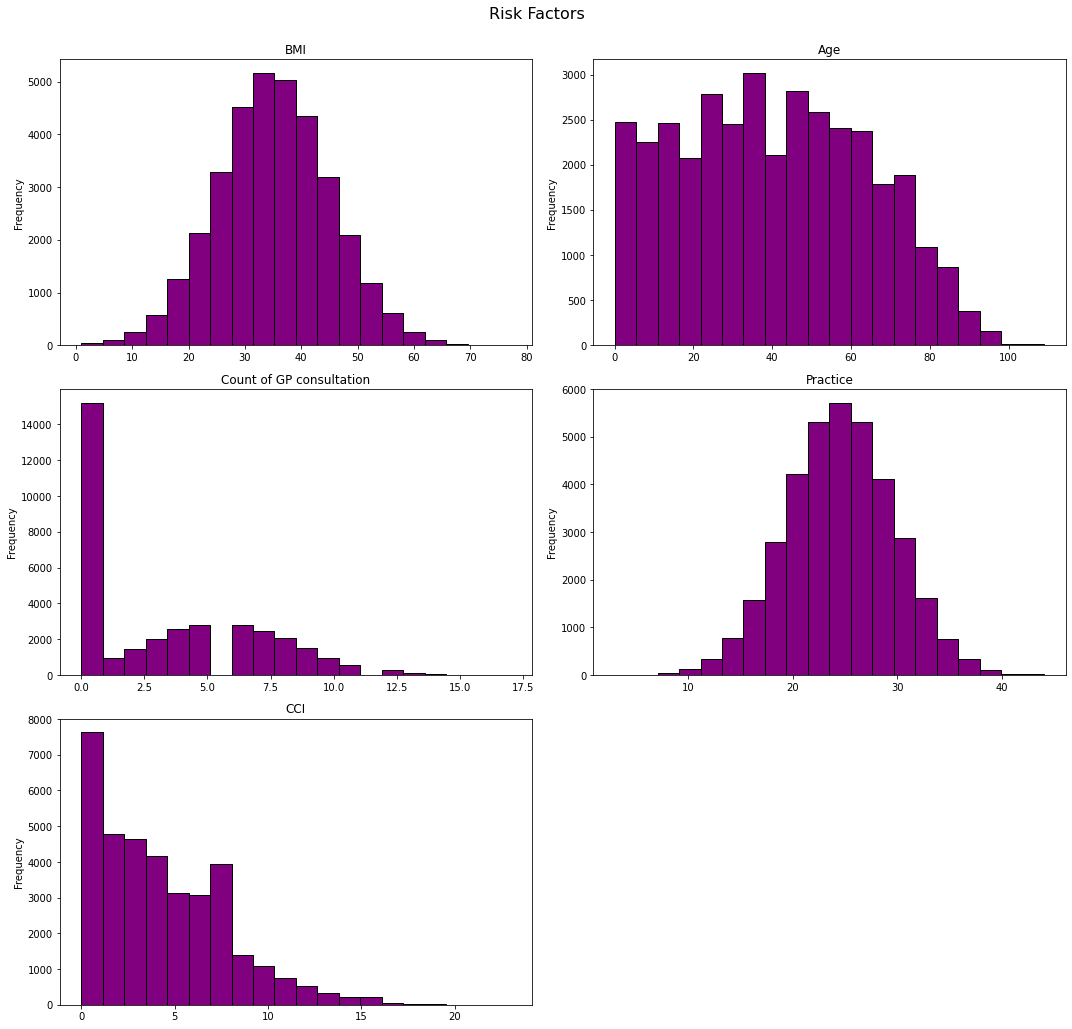

In [18]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

In [589]:
# print(list(data.columns))

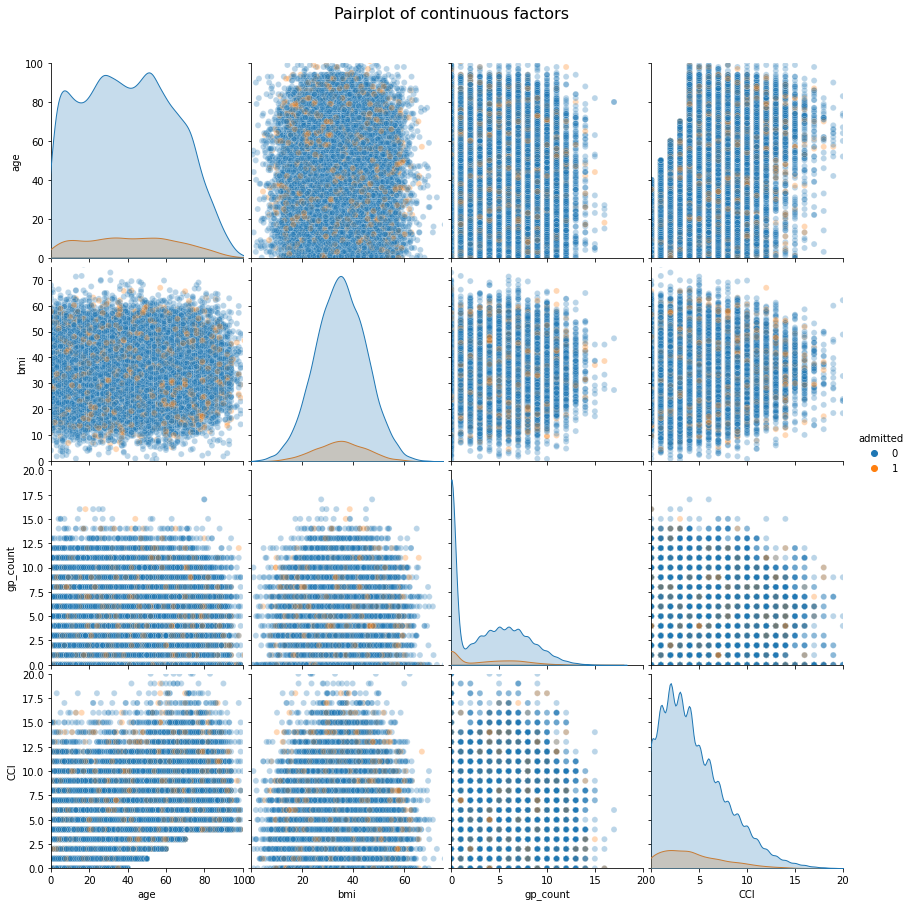

In [20]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_brit', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

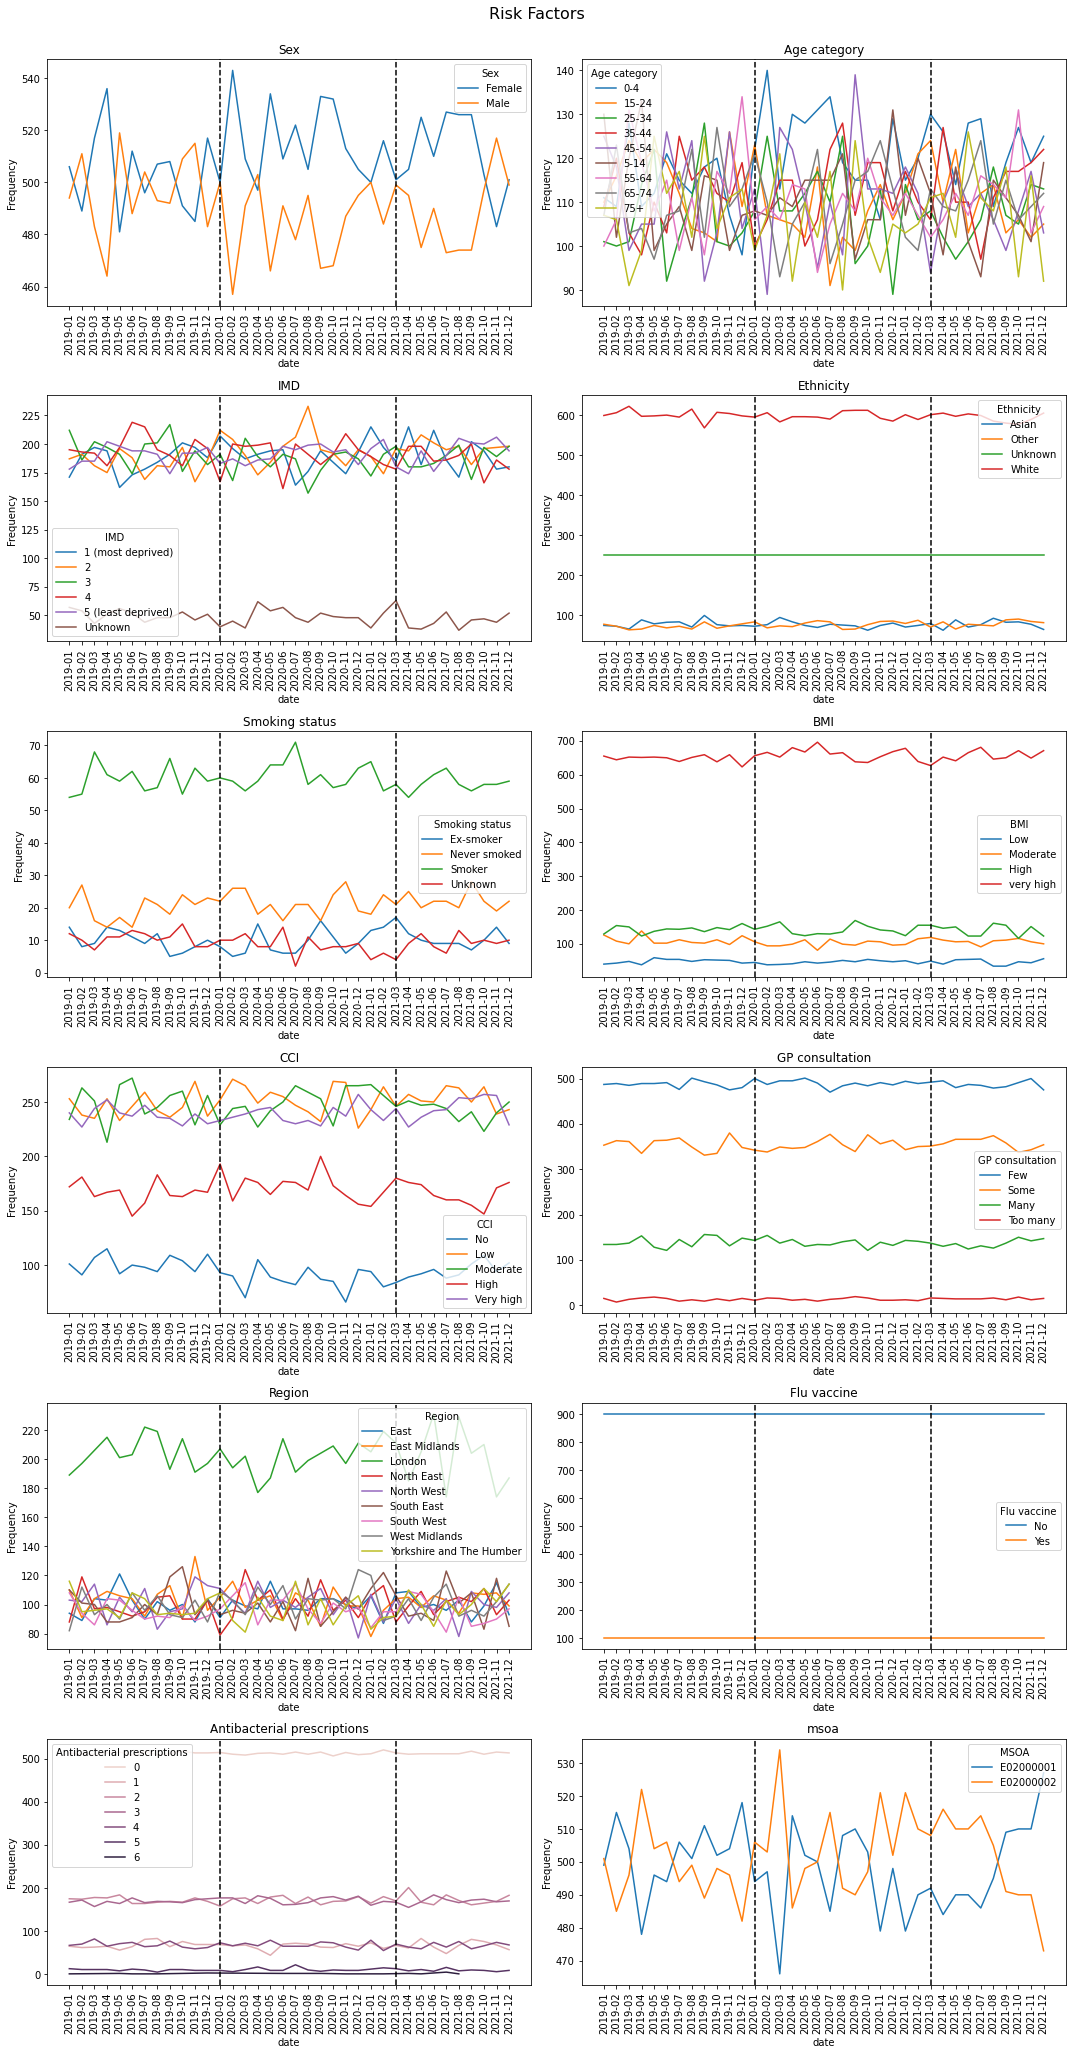

In [21]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- UTI

In [22]:
data.shape

(36000, 233)

In [460]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [461]:
def LoadData(InfectionKey, Index):
    data_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'gp_count_cat', 'flu_vaccine', 'region',
                   'smoking_status', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 
                   'died_date', 'deregistered_date',
                   'gp_cons_'+InfectionKey+'_'+str(Index), 'gp_cons_'+InfectionKey+'_ab_'+str(Index),
                   InfectionKey+'_date_'+str(Index), 'incdt_'+InfectionKey+'_date_'+str(Index), 'admitted_'+InfectionKey+'_date_'+str(Index),
                   'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)]]

    data_1 = data_1[data_1[InfectionKey+'_date_'+str(Index)].notnull()]

        # exclusion of covid positive 90 days before and 30 days after dx with uti_1
    data_1 = data_1[data_1['sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)] == 0]

    data_1.rename(columns={InfectionKey+'_date_'+str(Index): InfectionKey+'_date',
                                                    'incdt_'+InfectionKey+'_date_'+str(Index): 'incdt_'+InfectionKey+'_date',
                                                    'gp_cons_'+InfectionKey+'_'+str(Index): 'gp_cons_'+InfectionKey,
                                                    'gp_cons_'+InfectionKey+'_ab_'+str(Index): 'gp_cons_'+InfectionKey+'_ab',
                                                    'incdt_'+InfectionKey+'_date_'+str(Index): 'incdt_'+InfectionKey+'_date',
                                                    'admitted_'+InfectionKey+'_date_'+str(Index): 'admitted_'+InfectionKey+'_date',
                                                    'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index): 'sgss_gp_cov_'+InfectionKey+'_date'},
                                                    inplace=True)
    
    #convert types
    data_1[InfectionKey+'_date'] = data_1[InfectionKey+'_date'].astype('datetime64[ns]')
    data_1['admitted_'+InfectionKey+'_date'] = data_1['admitted_'+InfectionKey+'_date'].astype('datetime64[ns]')
    data_1.died_date = data_1.died_date.astype('datetime64[ns]')
    data_1.deregistered_date = data_1.deregistered_date.astype('datetime64[ns]')

    #censor patients that were not hosped
    #data_1 = data_1[data_1['admitted_'+InfectionKey+'_date'].notnull()]
    data_1.loc[data_1['admitted_'+InfectionKey+'_date'].notnull(), 'event_'+InfectionKey+'_admitted'] = 0
    
    #calculating days between infection dx and hosp
    data_1['delta_'+InfectionKey+'_admitted'] = (data_1['admitted_'+InfectionKey+'_date'] - data_1[InfectionKey+'_date']).dt.days
    
    #censor died patients
    data_1['delta_admitted_died'] = (data_1['died_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
    #data_1 = data_1[data_1['delta_'+InfectionKey+'_admitted'] > 0]
    data_1.loc[data_1['delta_admitted_died'] > 0, 'event_'+InfectionKey+'_admitted'] = 0

    #censor deregistered patients
    data_1['delta_admitted_deregistered'] = (data_1['deregistered_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
    data_1.loc[((data_1['delta_admitted_deregistered'] > 0) & (data_1['delta_admitted_deregistered'] < 30)), 'event_'+InfectionKey+'_admitted'] = 0

    #censor patients that had a history of hospital admission
    # data_1.loc[data_1['hx_hosp'] == 1, 'event_'+InfectionKey+'_admitted'] = 0
    #uncensor any other patients
    data_1['event_'+InfectionKey+'_admitted'] = data_1['event_'+InfectionKey+'_admitted'].replace(np.NaN, 1)

    #assign values for duration column
    data_1['duration_'+InfectionKey+'_admitted'] = data_1['delta_'+InfectionKey+'_admitted'].combine_first(data_1['delta_admitted_died'])
    data_1['duration_'+InfectionKey+'_admitted'] = data_1['duration_'+InfectionKey+'_admitted'].replace(np.NaN, 30)

    return data_1

In [462]:
# def LoadData(InfectionKey, Index):
#     for  i in range(1, Index+1): 
#         # data_1[i] = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#         #                 'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#         #                 'gp_cons_'+InfectionKey+'_'+str(i), 'gp_cons_'+InfectionKey+'_ab_'+str(i),
#         #                 InfectionKey+'_date_'+str(i), 'incdt_'+InfectionKey+'_date_'+str(i), 'admitted_'+InfectionKey+'_date_'+str(Index),
#         #                 'sgss_gp_cov_'+InfectionKey+'_date_'+str(i)]]

#         data_1[str(i)] = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#                         'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#                         'gp_cons_'+InfectionKey+'_'+str(i), 'gp_cons_'+InfectionKey+'_ab_'+str(i),
#                         InfectionKey+'_date_'+str(i), 'incdt_'+InfectionKey+'_date_'+str(i), 'admitted_'+InfectionKey+'_date_'+str(Index),
#                         'sgss_gp_cov_'+InfectionKey+'_date_'+str(i)]]        

#         data_1 = data_1[data_1[InfectionKey+'_date_'+str(i)].notnull()]

#         # exclusion of covid positive 90 days before and 30 days after dx with uti_1
#         data_1 = data_1[data_1['sgss_gp_cov_'+InfectionKey+'_date_'+str(i)] == 0]

#         data_1.rename(columns={InfectionKey+'_date_'+str(i): InfectionKey+'_date',
#                                                     'incdt_'+InfectionKey+'_date_'+str(i): 'incdt_'+InfectionKey+'_date',
#                                                     'gp_cons_'+InfectionKey+'_'+str(i): 'gp_cons_'+InfectionKey,
#                                                     'gp_cons_'+InfectionKey+'_ab_'+str(i): 'gp_cons_'+InfectionKey+'_ab',
#                                                     'incdt_'+InfectionKey+'_date_'+str(i): 'incdt_'+InfectionKey+'_date',
#                                                     'admitted_'+InfectionKey+'_date_'+str(i): 'admitted_'+InfectionKey+'_date',
#                                                     'sgss_gp_cov_'+InfectionKey+'_date_'+str(i): 'sgss_gp_cov_'+InfectionKey+'_date'},
#                                                     inplace=True)
#         data_1.append(data_1[i])

#     data_2 = pd.concat(data_1, axis=0, ignore_index=True)

#     #convert 
#     # data_1[InfectionKey+'_date'] = data_1[InfectionKey+'_date'].astype('datetime64[ns]')
#     # data_1['admitted_'+InfectionKey+'_date'] = data_1['admitted_'+InfectionKey+'_date'].astype('datetime64[ns]')
#     # data_1.died_date = data_1.died_date.astype('datetime64[ns]')

#     # #removing any row with no hosp record
#     # data_1 = data_1[data_1['admitted_'+InfectionKey+'_date'].notnull()]
#     # #calculating days between infection dx and hosp
#     # data_1['delta_'+InfectionKey+'_admitted'] = (data_1['admitted_'+InfectionKey+'_date'] - data_1[InfectionKey+'_date']).dt.days
#     # #remove whoever died after getting hosp
#     # data_1['delta_admitted_died'] = (data_1['died_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
#     # #data_1 = data_1[data_1['delta_'+InfectionKey+'_admitted'] > 0]

#     # #censor died cases
#     # data_1.loc[data_1['delta_admitted_died'] > 30, 'event_'+InfectionKey+'_admitted'] = 0
#     # #censor cases that had a history of hospital admission
#     # data_1.loc[data_1['hx_hosp'] == 1, 'event_'+InfectionKey+'_admitted'] = 0
#     # #censor cases that left ??
    

#     # #uncensor any other cases
#     # data_1['event_'+InfectionKey+'_admitted'] = data_1['event_'+InfectionKey+'_admitted'].replace(np.NaN, 1)

#     # #assign values for duration column
#     # data_1['duration_'+InfectionKey+'_admitted'] = data_1['delta_'+InfectionKey+'_admitted'].combine_first(data_1['delta_admitted_died'])

#     #splitting data into 
#     # data_2 = data_1[data_1['gp_cons_'+InfectionKey+'_ab'].isnull()]
#     # data_2 = data_2[data_2['incdt_'+InfectionKey+'_date'] == 0]

#     # data_3 = data_1[data_1['gp_cons_'+InfectionKey+'_ab'].notnull()]
#     # data_3 = data_3[data_3['incdt_'+InfectionKey+'_date'] == 0]

#     # data_4 = data_1[data_1['gp_cons_uti_ab'].isnull()]
#     # data_4 = data_4[data_4['incdt_uti_date'] == 1]

#     # data_5 = data_1[data_1['gp_cons_uti_ab'].notnull()]
#     # data_5 = data_5[data_5['incdt_uti_date'] == 1]

#     # return [data_2, data_3, data_4, data_5]
#     return data_2

In [463]:
ConvertColumns("uti", 4)

data_uti_1 = LoadData("uti", 1)
data_uti_2 = LoadData("uti", 2)
data_uti_3 = LoadData("uti", 3)
data_uti_4 = LoadData("uti", 4)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(3411, 29)

In [464]:
# data_uti#.delta_admitted_deregistered.value_counts()
# data_uti[~np.isnan(data_uti.delta_admitted_deregistered)].head(20)

In [465]:
ConvertColumns("urti", 4)

data_urti_1 = LoadData("urti", 1)
data_urti_2 = LoadData("urti", 2)
data_urti_3 = LoadData("urti", 3)
data_urti_4 = LoadData("urti", 4)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(3505, 29)

In [91]:
# ConvertColumns("uti", 4)
# data_uti = LoadData("uti", 4)
# data_uti.shape

In [22]:
# data_uti = LoadData("uti", 4)
# data_urti = LoadData("urti", 4)

(1915, 25)

In [24]:
# fig, ax = plt.subplots(figsize=(9, 7))
# sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count' ]].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=0, fontsize=12)                        
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/corr_uti.jpg')
# plt.show()

#### Separate data of UTI
We separate data of UTI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [466]:
# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]
data_uti_no_abs_incdt.shape

(2726, 29)

In [467]:
# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]
data_uti_abs_incdt.shape

(326, 29)

In [468]:
# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]
data_uti_no_abs_prevl.shape

(321, 29)

In [469]:
# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]
data_uti_abs_prevl.shape

(38, 29)

### 3-2- URTI

#### Adding event and duration columns for URTI

In [110]:
# data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
# data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
# #data_urti['incdt_urti_date'] = data_urti['incdt_urti_date'].astype('datetime64[ns]')
# data_urti['died_date'] = data_urti['died_date'].astype('datetime64[ns]')
# data_urti.shape

(3851, 25)

In [111]:
# # drop any case that has no admitted_urti_date
# data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
# data_urti.shape

(3851, 25)

In [31]:
# #I should ensure that incdt_urti_date is the same as urti_date and then apply this section for the entire urti data
# # data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['incdt_urti_date']).dt.days
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
# data_urti['delta_urti_admitted'].value_counts()

In [113]:
# # I deactivate this cell because I think dummy data leads to  
# data_urti.loc[data_urti['delta_urti_admitted'] > 30, 'delta_urti_admitted'] = 0
# data_urti.loc[data_urti['delta_urti_admitted'] < 0, 'delta_urti_admitted'] = 0 
# data_urti['delta_urti_admitted'].value_counts()

In [114]:
# data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days

# #give nan to any case that died before admission! (this happens because of dummy data??)
# # data_urti.loc[data_urti['delta_urti_admitted'] < 0, 'delta_urti_admitted'] = np.nan
# data_urti = data_urti[data_urti['delta_urti_admitted'] > 0]

# data_urti['delta_admitted_died'].isnull().sum()

1741

In [115]:
# #censor died cases
# data_urti.loc[data_urti['delta_admitted_died'] > 30, 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

1.0    1407
0.0     508
Name: event_urti_admitted, dtype: int64

In [32]:
# #censor cases that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

In [117]:
# #uncensor any other cases
# data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 1)
# data_urti['event_urti_admitted'].value_counts()

1.0    1407
0.0     508
Name: event_urti_admitted, dtype: int64

In [33]:
# #assign values for duration column
# data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died'])
# data_urti['duration_urti_admitted']#.value_counts()

In [119]:
# fig, ax = plt.subplots(figsize=(9, 7))
# sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count' ]].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=0, fontsize=12)                        
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/corr_urti.jpg')
# plt.show()

In [120]:
data_urti.shape

(1915, 25)

#### Separate data of URTI
We separate data of URI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [76]:
data_urti['gp_cons_urti_ab'].isnull().sum()

3154

In [77]:
data_urti['incdt_urti_date'].value_counts()

0    3156
1     349
Name: incdt_urti_date, dtype: int64

In [144]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]
data_urti_no_abs_incdt.shape

(2836, 27)

In [145]:
# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]
data_urti_abs_incdt.shape

(320, 27)

In [146]:
# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['urti_date'].notnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]
data_urti_no_abs_prevl.shape

(318, 27)

In [147]:
# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['urti_date'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]
data_urti_abs_prevl.shape

(31, 27)

## 4- Cox modelling for hospital admissions related to infections 
### 4-1- UTI

In [470]:
data_uti_no_abs_incdt.shape

(2726, 29)

In [471]:
data_uti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'gp_count_cat',
       'flu_vaccine', 'region', 'smoking_status', 'antibacterial_brit', 'imd',
       'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
       'deregistered_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'admitted_uti_date', 'sgss_gp_cov_uti_date',
       'event_uti_admitted', 'delta_uti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'duration_uti_admitted'],
      dtype='object')

In [472]:
# def CoxModel(InfectionKey):
#     data_uti_no_abs_incdt_nonan = data_uti_no_abs_incdt[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
#                                     'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
#                                     'CCI_cat', 'CCI', 'smoking_status',
#                                     'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

#     data_uti_abs_incdt_nonan = data_uti_abs_incdt[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
#                                     'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
#                                     'CCI_cat', 'CCI', 'smoking_status',
#                                     'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

#     data_uti_no_abs_prevl_nonan = data_uti_no_abs_prevl[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
#                                     'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
#                                     'CCI_cat', 'CCI', 'smoking_status',
#                                     'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]
    
#     # data_uti_abs_prevl_nonan = data_uti_abs_prevl[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
#     #                                 'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
#     #                                 'CCI_cat', 'CCI', 'smoking_status',
#     #                                 'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

#     # #drop rows with na 
#     # data_uti_no_abs_incdt_nonan = data_uti_no_abs_incdt_nonan.dropna(axis='rows')
#     # data_uti_abs_incdt_nonan = data_uti_abs_incdt_nonan.dropna(axis='rows')

#     #cph model
#     cph_uti_no_abs_incdt = CoxPHFitter().fit(data_uti_no_abs_incdt_nonan, 
#                                         duration_col='duration_uti_admitted',
#                                         event_col='event_uti_admitted',
#                                         formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

#     cph_uti_abs_incdt = CoxPHFitter().fit(data_uti_abs_incdt_nonan, 
#                                         duration_col='duration_uti_admitted',
#                                         event_col='event_uti_admitted',
#                                         formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

#     cph_uti_no_abs_prevl = CoxPHFitter(penalizer=0.1).fit(data_uti_no_abs_prevl_nonan, 
#                                         duration_col='duration_uti_admitted',
#                                         event_col='event_uti_admitted',
#                                         formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count
    
#     cph_uti_abs_prevl = CoxPHFitter(penalizer=0.1).fit(data_uti_no_abs_prevl_nonan, 
#                                         duration_col='duration_uti_admitted',
#                                         event_col='event_uti_admitted',
#                                         formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

#     # #print cph summary
#     # cph_uti_no_abs_incdt.summary        
#     # cph_uti_no_abs_incdt.print_summary(#style="html",
#     #                                    columns=[]#["coef", "se(coef)", "p"])

#     fig, axes = plt.subplots(2,2,
#                         figsize=(15, 20)
#                         )
#     a1 = cph_uti_no_abs_incdt.plot(ax=axes[0,0])
#     a1.title('No abs incdt')
#     a2 = cph_uti_abs_incdt.plot(ax=axes[0,1])
#     plt.title('Abs incdt')
#     a3 = cph_uti_no_abs_prevl.plot(ax=axes[1,0])
#     plt.title('Abs incdt')
#     a4 = cph_uti_abs_prevl.plot(ax=axes[1,1])
#     plt.title('Abs incdt')
#     # fig.delaxes(ax=axes[1,1])

#     fig.suptitle('Coefficients of CPH model for incident hospital admission related to '+InfectionKey+' with no antibiotics', fontsize=16)
#     fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    
#     #save models
#     with open('output/hospitalisation_prediction/cph_uti_no_abs_incdt.pickle', 'wb') as f:
#         pickle.dump(cph_uti_no_abs_incdt, f)
#     with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#         pickle.dump(cph_uti_abs_incdt, f)
#     with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'wb') as f:
#         pickle.dump(cph_uti_no_abs_prevl, f)
#     with open('output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'wb') as f:
#         pickle.dump(cph_uti_abs_prevl, f)

In [473]:
def CoxModel(InfectionKey):
    data_uti_no_abs_incdt_nonan = data_uti_no_abs_incdt[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
                                    'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
                                    'CCI_cat', 'CCI', 'smoking_status',
                                    'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

    data_uti_abs_incdt_nonan = data_uti_abs_incdt[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
                                    'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
                                    'CCI_cat', 'CCI', 'smoking_status',
                                    'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

    data_uti_no_abs_prevl_nonan = data_uti_no_abs_prevl[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
                                    'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
                                    'CCI_cat', 'CCI', 'smoking_status',
                                    'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]
    
    # data_uti_abs_prevl_nonan = data_uti_abs_prevl[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
    #                                 'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd', 'ethnicity', 
    #                                 'CCI_cat', 'CCI', 'smoking_status',
    #                                 'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

    # #drop rows with na 
    # data_uti_no_abs_incdt_nonan = data_uti_no_abs_incdt_nonan.dropna(axis='rows')
    # data_uti_abs_incdt_nonan = data_uti_abs_incdt_nonan.dropna(axis='rows')

    #cph model
    cph_uti_no_abs_incdt = CoxPHFitter().fit(data_uti_no_abs_incdt_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

    cph_uti_abs_incdt = CoxPHFitter().fit(data_uti_abs_incdt_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

    cph_uti_no_abs_prevl = CoxPHFitter(penalizer=0.1).fit(data_uti_no_abs_prevl_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count
    
    cph_uti_abs_prevl = CoxPHFitter(penalizer=0.1).fit(data_uti_no_abs_prevl_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

    # #print cph summary
    # cph_uti_no_abs_incdt.summary        
    # cph_uti_no_abs_incdt.print_summary(#style="html",
    #                                    columns=[]#["coef", "se(coef)", "p"])

    fig, axes = plt.subplots(2,2,
                        figsize=(15, 20)
                        )
    plt.subplot(2, 2, 1)
    cph_uti_no_abs_incdt.plot()#ax=axes[0,0])
    plt.title('Incident with no antibiotics', fontsize=14)

    plt.subplot(2, 2, 2)
    cph_uti_abs_incdt.plot()#ax=axes[0,1])
    plt.title('Incident with antibiotics', fontsize=14)
    
    plt.subplot(2, 2, 3)
    cph_uti_no_abs_prevl.plot()#ax=axes[1,0])
    plt.title('Prevalent with no antibiotics', fontsize=14)
    
    plt.subplot(2, 2, 4)
    cph_uti_abs_prevl.plot()#ax=axes[1,1])
    plt.title('Prevalent with antibiotics', fontsize=14)
    # fig.delaxes(ax=axes[1,1])

    fig.suptitle('Coefficients of CPH model for incident hospital admission related to '+InfectionKey+' with no antibiotics', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig('../output/repeat_ABs_outputs/coefficients_cph_uti.jpg', bbox_inches='tight')
    
    #save models
    with open('output/hospitalisation_prediction/cph_uti_no_abs_incdt.pickle', 'wb') as f:
        pickle.dump(cph_uti_no_abs_incdt, f)
    with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
        pickle.dump(cph_uti_abs_incdt, f)
    with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'wb') as f:
        pickle.dump(cph_uti_no_abs_prevl, f)
    with open('output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'wb') as f:
        pickle.dump(cph_uti_abs_prevl, f)

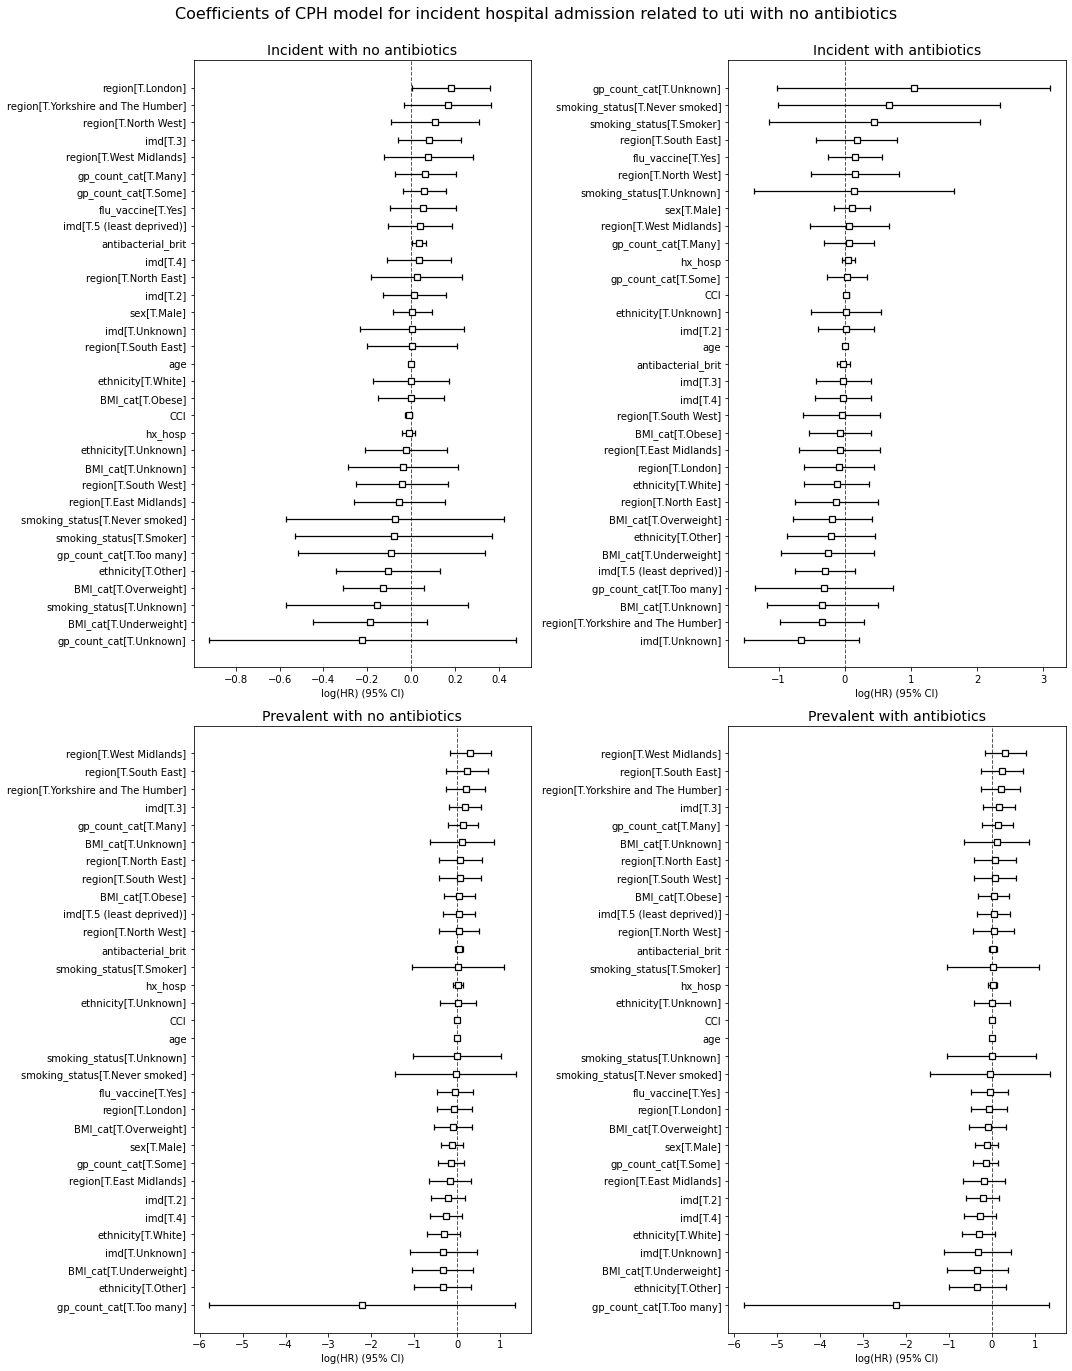

In [474]:
CoxModel("uti")
    # with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
    #     cph_uti_abs_incdt = pickle.load(f)

In [478]:
from lifelines.utils import k_fold_cross_validation

In [ ]:
#https://stats.stackexchange.com/questions/488992/predictions-using-coxtimevaryingfitter-for-survival-analysis-in-python/489006#489006
#https://lifelines.readthedocs.io/en/latest/lifelines.utils.html

In [490]:
data_uti_no_abs_incdt_1 = data_uti_no_abs_incdt[['age', 'sex', 'ethnicity', 'smoking_status', 'imd', 'region', 
                                                 'BMI_cat', 'CCI', 'flu_vaccine', 'gp_count_cat', 'antibacterial_brit', 
                                                 'hx_hosp', 'duration_uti_admitted', 'event_uti_admitted']]

In [491]:
cph_uti_no_abs_incdt = CoxPHFitter().fit(data_uti_no_abs_incdt_1, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count


In [506]:
data_uti_abs_incdt_1 = data_uti_abs_incdt[['age', 'sex', 'ethnicity', 'smoking_status', 'imd', 'region', 
                                                 'BMI_cat', 'CCI', 'flu_vaccine', 'gp_count_cat', 'antibacterial_brit', 
                                                 'hx_hosp', 'duration_uti_admitted', 'event_uti_admitted'
                                                 ]].loc[[13]]

In [507]:
data_uti_abs_incdt_1.columns

Index(['age', 'sex', 'ethnicity', 'smoking_status', 'imd', 'region', 'BMI_cat',
       'CCI', 'flu_vaccine', 'gp_count_cat', 'antibacterial_brit', 'hx_hosp',
       'duration_uti_admitted', 'event_uti_admitted'],
      dtype='object')

In [509]:
# cph_uti_no_abs_incdt.score(data_uti_abs_incdt_1, scoring_method="log_likelihood")

In [510]:
# scores = k_fold_cross_validation(cph_uti_no_abs_incdt, data_uti_no_abs_incdt_1, 
#                                  'duration_uti_admitted', event_col='event_uti_admitted', k=3)

### 4-2- URTI
#### 4-2-1- Incident hospital admission related to URTI with no antibiotics

In [514]:
data_urti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date',
       'delta_urti_admitted', 'delta_admitted_died', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [515]:
data_urti_no_abs_incdt.shape

(1629, 25)

In [516]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                               'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                               'event_urti_admitted', 'duration_urti_admitted']]

In [517]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age                        0
age_cat                    0
sex                        0
bmi                       97
BMI_cat                   97
gp_count                  13
flu_vaccine                0
region                     0
antibacterial_brit         0
imd                        0
ethnicity                  0
CCI_cat                    0
CCI                        0
event_urti_admitted        0
duration_urti_admitted     0
dtype: int64

In [518]:
#drop ros with missing values
data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.drop(columns=['smoking_status'])
data_urti_no_abs_incdt.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                       0
BMI_cat                   0
gp_count                  0
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [519]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt, 
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_urti_no_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 1519 total observations, 420 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1519
number of events observed = 1099
   partial log-likelihood = -6937.90
         time fit was run = 2022-02-03 13:27:52 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                     0.03       1.03       0.13            -0.21             0.28                 0.81                 1.33
age_cat[T.25-34]                    -0.22       0.81       0.13            -0.47             0.04                 0.62                 1.04
age_cat[T.35-44]                    -0.09       0.91       0.13            -0.34             0.16                 0.71                 1.17
age_cat[T.45-54]                    -0.09       0.91       0.13            -0.34             0.16                 0.71                 1.18
age_cat[T.5-14]                     -0.14       0.87       0.13            -0.39             0.10                 0.68                 1.11
age_cat[T.55-64]                     0.03       1.03       0.13            -0.22             0.27                 0.80                 1.31
age_cat[T.65-74]                     0.03       1.03       0.12            -0.22             0.27                 0.81                 1.31
age_cat[T.75+]                      -0.00       1.00       0.13            -0.26             0.26                 0.77                 1.29
antibacterial_brit                  -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.03
ethnicity[T.Other]                   0.22       1.25       0.16            -0.09             0.54                 0.91                 1.71
ethnicity[T.Unknown]                 0.10       1.10       0.13            -0.15             0.34                 0.86                 1.41
ethnicity[T.White]                   0.11       1.11       0.11            -0.12             0.33                 0.89                 1.39
flu_vaccine[T.Yes]                   0.13       1.14       0.10            -0.06             0.32                 0.94                 1.38
gp_count                            -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
imd[T.2]                            -0.04       0.96       0.10            -0.24             0.16                 0.79                 1.18
imd[T.3]                            -0.25       0.78       0.10            -0.45            -0.06                 0.64                 0.95
imd[T.4]                            -0.05       0.95       0.10            -0.24             0.14                 0.79                 1.15
imd[T.5 (least deprived)]           -0.00       1.00       0.10            -0.20             0.19                 0.82                 1.21
imd[T.Unknown]                      -0.18       0.83       0.14            -0.45             0.09                 0.64                 1.09
region[T.East Midlands]              0.09       1.10       0.13            -0.17             0.36                 0.85                 1.43
region[T.London]                     0.13       1.14       0.12            -0.11             0.37                 0.90                 1.45
region[T.North East]                 0.14       1.15       0.14            -0.13             0.40                 0.88                 1.49
region[T.North West]                 0.13       1.13       0.14            -0.15             0.40                 0.86                 1.50
region[T.South East]                -0.01       0.99       0.14            -0.30             0.27          

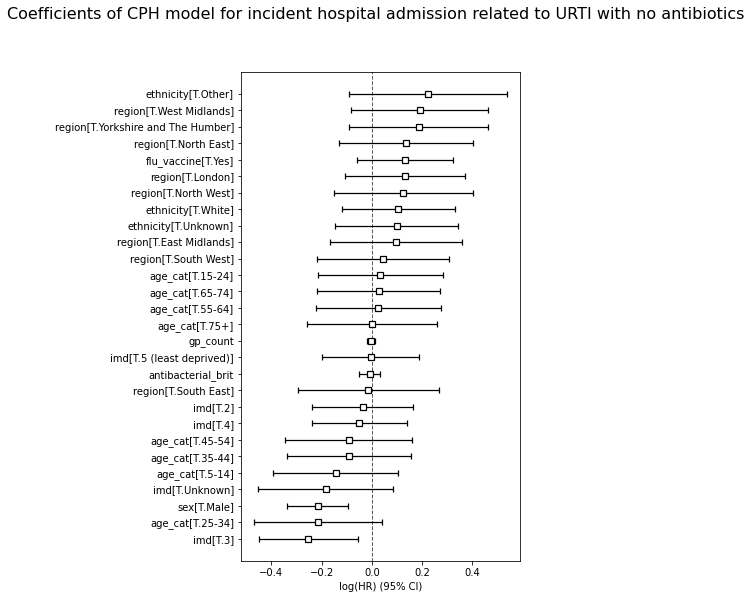

In [520]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
#     cph_uti_abs_incdt = pickle.load(f)

# cph_uti_abs_incdt.summary

### 4-2-2- Incident hospital admission related to URTI with antibiotics

In [521]:
data_urti_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date',
       'delta_urti_admitted', 'delta_admitted_died', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [522]:
data_urti_abs_incdt.shape

(182, 25)

In [523]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                        'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                        'event_urti_admitted', 'duration_urti_admitted']]

In [524]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age                        0
age_cat                    0
sex                        0
bmi                       11
BMI_cat                   11
gp_count                   1
flu_vaccine                0
region                     0
antibacterial_brit         0
imd                        0
ethnicity                  0
CCI_cat                    0
CCI                        0
event_urti_admitted        0
duration_urti_admitted     0
dtype: int64

In [525]:
#drop ros with missing values
data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
#data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
data_urti_abs_incdt.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                       0
BMI_cat                   0
gp_count                  0
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [526]:
data_urti_abs_incdt.shape

(170, 15)

In [528]:
cph_urti_abs_incdt = CoxPHFitter(penalizer=0.1)
cph_urti_abs_incdt.fit(data_urti_abs_incdt, 
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 170 total observations, 45 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 170
number of events observed = 125
   partial log-likelihood = -515.96
         time fit was run = 2022-02-03 13:30:33 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                     0.10       1.10       0.31            -0.50             0.70                 0.61                 2.02
age_cat[T.25-34]                     0.17       1.19       0.33            -0.47             0.82                 0.62                 2.27
age_cat[T.35-44]                    -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.87
age_cat[T.45-54]                    -0.07       0.93       0.38            -0.81             0.66                 0.44                 1.94
age_cat[T.5-14]                      0.21       1.23       0.32            -0.41             0.83                 0.66                 2.29
age_cat[T.55-64]                    -0.01       0.99       0.32            -0.63             0.62                 0.53                 1.86
age_cat[T.65-74]                     0.63       1.88       0.32             0.00             1.27                 1.00                 3.54
age_cat[T.75+]                      -0.16       0.85       0.32            -0.79             0.47                 0.45                 1.61
antibacterial_brit                   0.09       1.09       0.06            -0.04             0.21                 0.96                 1.24
ethnicity[T.Other]                  -0.51       0.60       0.56            -1.60             0.58                 0.20                 1.79
ethnicity[T.Unknown]                -0.26       0.77       0.27            -0.79             0.27                 0.45                 1.31
ethnicity[T.White]                  -0.16       0.85       0.24            -0.64             0.31                 0.53                 1.37
flu_vaccine[T.Yes]                   0.32       1.37       0.39            -0.45             1.09                 0.64                 2.96
gp_count                             0.00       1.00       0.03            -0.05             0.05                 0.95                 1.06
imd[T.2]                             0.07       1.07       0.29            -0.50             0.64                 0.61                 1.90
imd[T.3]                            -0.29       0.75       0.25            -0.78             0.19                 0.46                 1.21
imd[T.4]                             0.15       1.16       0.26            -0.37             0.66                 0.69                 1.94
imd[T.5 (least deprived)]           -0.18       0.84       0.28            -0.73             0.38                 0.48                 1.46
imd[T.Unknown]                       0.18       1.20       0.50            -0.80             1.16                 0.45                 3.18
region[T.East Midlands]             -0.11       0.89       0.33            -0.76             0.54                 0.47                 1.71
region[T.London]                    -0.19       0.83       0.30            -0.79             0.41                 0.46                 1.51
region[T.North East]                -0.17       0.85       0.36            -0.87             0.54                 0.42                 1.71
region[T.North West]                 0.19       1.21       0.33            -0.46             0.84                 0.63                 2.33
region[T.South East]                -0.62       

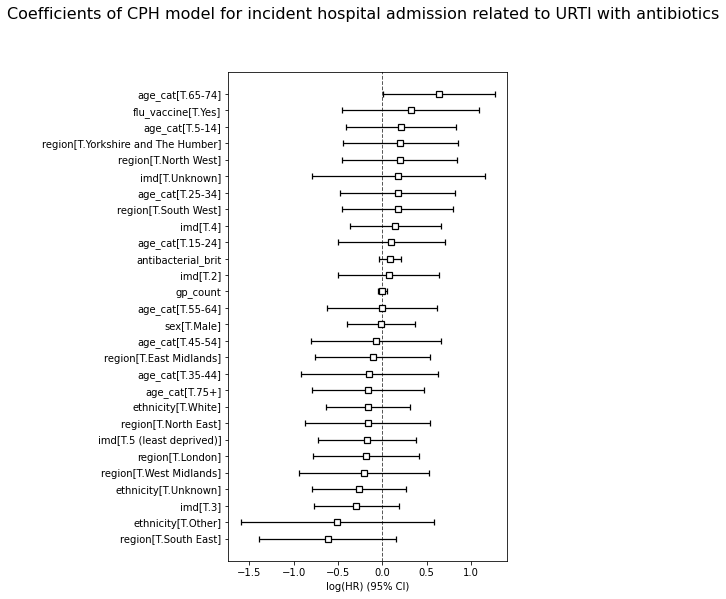

In [529]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_urti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_urti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_urti_abs_incdt.pickle', 'rb') as f:
#     cph_urti_abs_incdt = pickle.load(f)

# cph_urti_abs_incdt.summary

### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [ ]:
# hosp history, ab type history, 